In [20]:
import pandas as pd
import numpy as np
import pickle
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

# Model evaluation on external GEO dataset

We will load the data stored in "all_data_geo.pkl" and "all_labels_geo.pkl", which were prepared by the previous notebook.

Changing the AUGMENTATION parameter selects the adequate model's file name, so we can test all of them.

In [3]:
# parameter to determine which model to load for validation
AUGMENTATION = 80

all_data_columns_file_path = "./all_data_columns.pkl"
encoder_file = f"./encoder_{AUGMENTATION}.pkl"
model_file_name = f"xgboost-{AUGMENTATION}.model"

In [5]:
# load GEO data from pickle file
all_labels_file_path = "all_labels_geo.pkl"
all_data_file_path = "all_data_geo.pkl"

with open(all_labels_file_path, 'rb') as f:
    all_labels_geo = pickle.load(f)

with open(all_data_file_path, 'rb') as f:
    all_data_geo = pickle.load(f)

# Cleaning the samples

GEO dataset might be containing some labels which TCGA model is not trained on, so we have to remove the respective rows in both labels and data DataFrames.

Similarly as in TCGA dataset preparation, some of the column names mught be duplicated (representing the same gene). We solve this by merging those colums by addition, since TMP(A+B) = TPM(A) + TPM(B).

In [10]:
# load label encoder from pickle file
with open(encoder_file, 'rb') as f:
    label_encoder = pickle.load(f)
class_list = label_encoder.classes_
print("Class list on which the model was trained on:")
print(class_list)

# set the index of both data frames to a simple range
all_data_geo["index"] = range(all_data_geo.shape[0])
all_data_geo.set_index("index", inplace=True)
all_labels_geo["index"] = range(all_labels_geo.shape[0])
all_labels_geo.set_index("index", inplace=True)

# remove the labels which model was not trained on
to_keep = all_labels_geo["Tissue"].map(lambda x: x in class_list)

labels_geo = all_labels_geo.loc[to_keep]
tpm_geo = all_data_geo.loc[to_keep]

# Get the count of samples for each unique label
label_counts = labels_geo["Tissue"].value_counts()

# Print the count of samples for each unique label
print("Label distribution:")
print(label_counts)

print(f'Total geo columns: {len(tpm_geo.columns)}')
print(f'Unique geo columns: {len(set(tpm_geo.columns))}')

# merging the columns with the same symbol name
data_geo = tpm_geo.groupby(tpm_geo.columns, axis=1).sum()
unique_columns = len(set(data_geo.columns))

Class list on which the model was trained on:
['bladder' 'brain' 'breast' 'colon' 'kidney' 'liver' 'lung' 'pancreas'
 'prostate' 'skin']
Label distribution:
Tissue
colon       285
liver       269
breast      235
kidney      224
brain       214
skin        210
pancreas    197
lung        187
prostate    140
bladder     137
Name: count, dtype: int64
Total geo columns: 39376
Unique geo columns: 39374


We can see there were two duplicated columns which we merged.

In [11]:
#open the list of genes from tcga
with open(all_data_columns_file_path, 'rb') as all_data_columns_pckl:
    all_data_columns = pickle.load(all_data_columns_pckl)

# Gene count alignment

Having in mind we are working with different databases we can expect that the features (gene counts/TPM values) don't match. Comparing to the original list of almost 60000 genes from TCGA, we can end up in two situations:
1. Some genes might be missing
2. Some genes might be extra

In order to be able to feed the GEO data to the classifier trained on TCGA data, the features must exactly match. This is why we will handle both of the problems stated above in two steps:
1. Add columns with zeroes which don't exist in GEO and did exist in TCGA
2. Remove the columns from GEO which didn't exist in TCGA

This way we guarantee the same set of columns during validation as we had during training. We also ensure the same ordering of the columns, not just the set.

In [16]:
print("GEO dataset feature columns: \t\t", len(data_geo.columns))
print("Classifier model expected input: \t", len(all_data_columns))

# Delete all columns from data_geo dataframe that are not present in all_data_columns list
columns_to_drop = [col for col in data_geo.columns if col not in all_data_columns]
print("Number of feature colums to remove: \t", len(columns_to_drop))

data_geo_filtered = data_geo.drop(columns=columns_to_drop)
print("Number of remaining feature columns: \t" , data_geo_filtered.shape[1])
      
# For each column name in all_data_columns list add a column of zeros to data_geo_filtered dataframe 
# if the column with that name does not exist, otherwise ignore it

# Create a DataFrame with zeros for missing columns
zeros_df = pd.DataFrame(0, index=data_geo_filtered.index, columns=all_data_columns)

# Concatenate data_geo_filtered and zeros_df
data_geo_filtered = pd.concat([data_geo_filtered, zeros_df], axis=1)

# Remove duplicate columns
data_geo_filtered = data_geo_filtered.loc[:, ~data_geo_filtered.columns.duplicated()]

# Construct validation dataset with proper column ordering defined in all_data_columns
data_geo_test = data_geo_filtered[all_data_columns]
print("Number of resulting feature columns: \t" , data_geo_test.shape[1])

GEO dataset feature columns: 		 39374
Classifier model expected input: 	 59427
Number of feature colums to remove: 	 12302
Number of remaining feature columns: 	 27072
Number of resulting feature columns: 	 59427


# Validate data geo on trained tcga classifier

We load the pretrained model from the pickle file.

In [17]:
# load the xgboost model
with open(model_file_name, 'rb') as f:
    model = pickle.load(f)

In [18]:
# encoding the test data with the same label encoder used in training
all_labels_encoded = label_encoder.transform(np.ravel(labels_geo))

# sort the data_geo_test columns
data_geo_test = data_geo_test[sorted(data_geo_test.columns)]

Verifying accuracy...
Accuracy of the test: 83.9371%
Precision: 0.8464
Recall: 0.8416
F1 Score: 0.8364


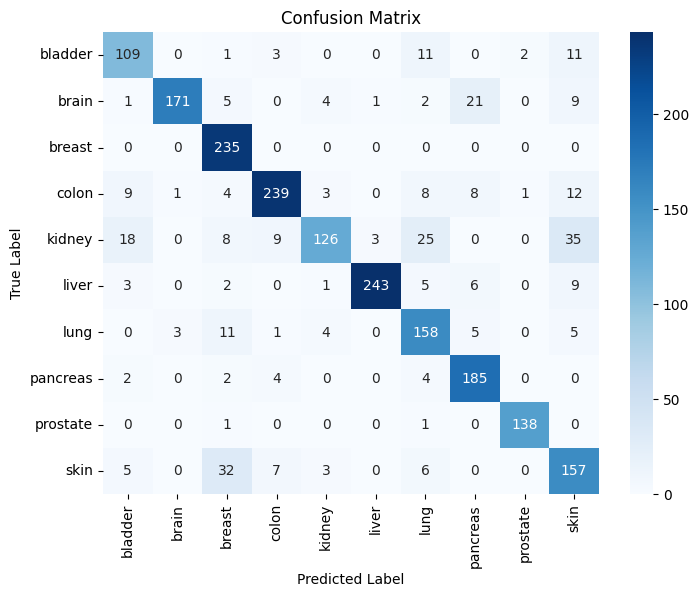

In [21]:
print("Verifying accuracy...")
# verify accuracy of the test data
pred_test = model.predict(data_geo_test)

accuracy = sum(pred_test == all_labels_encoded) / float(len(pred_test))
print("Accuracy of the test: %.4f%%" % (accuracy * 100.0))

# Calculate precision
precision = precision_score(all_labels_encoded, pred_test, average='macro')

# Calculate recall
recall = recall_score(all_labels_encoded, pred_test, average='macro')

# Calculate F1 score
f1 = f1_score(all_labels_encoded, pred_test, average='macro')

# Print the results
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))

confusion = sklearn.metrics.confusion_matrix(all_labels_encoded, pred_test)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

The accuracy on heavily depends on the data augmentation. 80% of drop-out augmentation increases the accuracy to 83.97% and F1-score to 0.8364.

Without augmentation the accuracy was 72.1% and F1-score was 0.7171.

In [44]:
print("Verifying accuracy for each cancer type...")

pred_test = model.predict(data_geo_test)
accuracy = sum(pred_test == all_labels_encoded) / float(len(pred_test))

accuracies = []
for i in range(len(class_list)):
    idx = all_labels_encoded == i
    pred_test_class = pred_test[idx]
    all_labels_class = all_labels_encoded[idx]

    accuracy_class = sum(pred_test_class == all_labels_class) / float(len(pred_test_class))
    accuracies.append(accuracy_class)
    print(f'Accuracy of class {class_list[i]}: \t{accuracy_class*100:.2f}%')

Verifying accuracy for each cancer type...
Accuracy of class bladder: 	79.56%
Accuracy of class brain: 	79.91%
Accuracy of class breast: 	100.00%
Accuracy of class colon: 	83.86%
Accuracy of class kidney: 	56.25%
Accuracy of class liver: 	90.33%
Accuracy of class lung: 	84.49%
Accuracy of class pancreas: 	93.91%
Accuracy of class prostate: 	98.57%
Accuracy of class skin: 	74.76%


In [46]:
# load TCGA labels so we can compare 
# the training distribution with test accuracies
with open("all_data_final.pkl", 'rb') as f:
    tcga_data = pickle.load(f)
tcga_labels = tcga_data.iloc[:, -1]

tcga_counts = pd.DataFrame(tcga_labels.value_counts()).loc[class_list]
comparison = pd.DataFrame({"GEO accuracy" : accuracies, "TCGA sample count" : tcga_counts["count"]})
comparison


,GEO accuracy,TCGA sample count
0,,
bladder,0.795620,428
brain,0.799065,843
breast,1.000000,1506
colon,0.838596,718
kidney,0.562500,1491
liver,0.903346,462
lung,0.844920,1753
pancreas,0.939086,398
prostate,0.985714,561


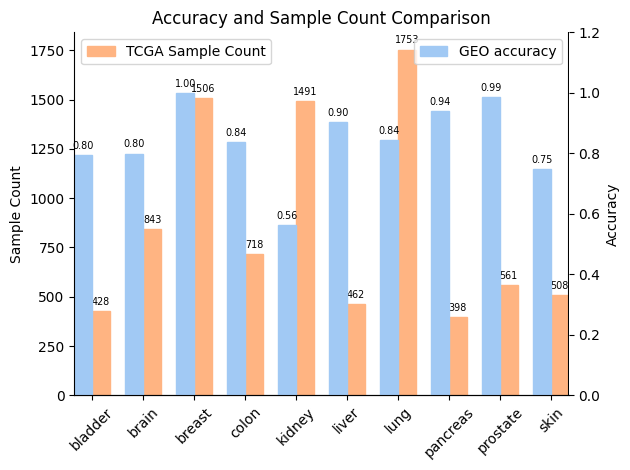

In [95]:
# Set a custom color palette with higher contrast
sns.set_palette("pastel")

# Create a numpy array for the x-axis positions
x = np.arange(len(comparison))

# Width of the bars
width = 0.35

# Create the figure and axes
fig, ax1 = plt.subplots()

# Create a second y-axis for accuracies
ax2 = ax1.twinx()

# Plot the bars for accuracy on the first y-axis with different colors
rects1 = ax2.bar(x - width/2, comparison['GEO accuracy'], width, label='GEO accuracy')

# Plot the bars for sample count on the second y-axis with different colors
rects2 = ax1.bar(x + width/2, comparison['TCGA sample count'], width, label='TCGA Sample Count')

# Set the colors of the bars
for i, rect in enumerate(rects1):
    rect.set_color(sns.color_palette()[0])  # Select every other color from the palette

for i, rect in enumerate(rects2):
    rect.set_color(sns.color_palette()[1])  # Select every other color from the palette


# Set the labels, title, and x-axis tick labels
ax1.set_ylabel('Sample Count')
ax2.set_ylabel('Accuracy')
ax1.set_title('Accuracy and Sample Count Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(comparison.index, rotation=45)

# Add values above the bars (sample count) with smaller font size
for rect in rects2:
    height = rect.get_height()
    ax1.annotate(f'{height}', xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points',
                ha='center', va='bottom', fontsize='x-small')

# Add values above the bars (accuracy) with smaller font size
for rect in rects1:
    height = rect.get_height()
    ax2.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points',
                ha='center', va='bottom', fontsize='x-small')

# Move the legend to the bottom right
lines, labels = ax1.get_legend_handles_labels()

# Adjust the spacing between the y-axis and the bars
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.yaxis.tick_left()
ax2.yaxis.tick_right()

# Set the x-axis position for the second group of bars
ax1.set_xlim(x[0] - width, x[-1] + width)

# Adjust the y-axis limits for the right y-axis (accuracy)
accuracy_max = comparison['GEO accuracy'].max()
ax2.set_ylim(0, accuracy_max + accuracy_max * 0.2)

# Plot the right edge of the chart
right_edge = x[-1] + width/2 + width/2
ax1.axvline(right_edge, color='black', linestyle='-')

ax1.legend(lines, labels, loc='upper left')
lines, labels = ax2.get_legend_handles_labels()
ax2.legend(lines, labels, loc='upper right')

# Display the chart
plt.tight_layout()
plt.show()

We can see that there is no clear correlation of the accuracy for individual cancer types with the relative amount of samples for that cancer type in training dataset.